In [ ]:
import seaborn as sns
import tifffile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
predictions = np.load("/net/mulan/home/huiwann/spatial/SVC/output/seqfish/prediction_all_genes_mu.npz")["prediction"]
truth_test = np.load(f"/net/mulan/home/huiwann/spatial/SVC/data/seqfish/test_seqfish.npz")["data_ori"]
truth_train = np.load(f"/net/mulan/home/huiwann/spatial/SVC/data/seqfish/train_seqfish.npz")["data_ori"]
print(predictions.shape)

gene_num = predictions.shape[1]

(14, 1000, 12, 12)


In [3]:
background_pixel = np.array([[0,0],[0,1],[0,10],[0,11],[1,0],[1,11],[10,0],[10,11],[11,0],[11,1],[11,10],[11,11]], dtype=np.int64)
foreground = np.ones((12, 12), dtype=bool)
foreground[background_pixel[:, 0], background_pixel[:, 1]] = False
foreground_pixels = (foreground==True).sum().item() 


In [ ]:
def make_baselines(predictions,truth_train):
    """
    truth_train: array of shape (n_cells_train, n_genes, H, W)
    return: baseline
    """
    n_cells_train, n_genes, H, W = truth_train.shape
    n_cells_test = predictions.shape[0]

    rand_cells = np.random.randint(0, n_cells_train, size=n_cells_test)        # shape (n_cells,)
    cell_idx = rand_cells[:, None]                                  # (n_cells, 1)
    gene_idx = np.arange(n_genes)[None, :]                          # (1, n_genes)

    baseline= truth_train[cell_idx, gene_idx, :, :]

    return baseline
    
def cosine_similarity(x1, x2, axis=1, eps=1e-8):
    dot_product = np.sum(x1 * x2, axis=axis)
    norm1 = np.linalg.norm(x1, axis=axis)
    norm2 = np.linalg.norm(x2, axis=axis)
    denom = norm1 * norm2

    cosine_sim = np.where(denom == 0, 0.0, dot_product / (denom + eps))
    return cosine_sim

In [5]:
from tqdm import tqdm
avg_rmse_SVC = []
avg_cosine_SVC = []
avg_pcc_SVC = []

for i in tqdm(range(gene_num)):
    
    pred_i = predictions[:,i]
    truth_i = truth_test[:,i]
    non_zero_image = truth_i.sum((-1,-2))!=0

    pred_i_flat, truth_i_flat = pred_i.reshape(pred_i.shape[0],-1), truth_i.reshape(truth_i.shape[0],-1)

    pcc_SVC_per_gene = []
    for j in range(truth_i.shape[0]):
        if non_zero_image[j]:
            pcc_SVC_per_gene.append(np.corrcoef(pred_i_flat[j], truth_i_flat[j])[0,1])
    rmse_SVC_per_gene = np.sqrt(np.sum((pred_i_flat - truth_i_flat)**2,axis=1)/foreground_pixels)### pixel求平均
    cosine_SVC_per_gene = cosine_similarity(pred_i_flat, truth_i_flat, axis=1)

    avg_rmse_SVC.append(rmse_SVC_per_gene.mean())### 
    avg_cosine_SVC.append(cosine_SVC_per_gene[non_zero_image].mean())
    avg_pcc_SVC.append(np.array(pcc_SVC_per_gene).mean())

avg_rmse_SVC = np.array(avg_rmse_SVC)
avg_cosine_SVC = np.array(avg_cosine_SVC)
avg_pcc_SVC = np.array(avg_pcc_SVC)

print("avg_rmse_SVC:",avg_rmse_SVC.mean())### 
print("avg_cosine_SVC:",avg_cosine_SVC.mean())
print("avg_pcc_SVC:",avg_pcc_SVC.mean())



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2113.97it/s]

avg_rmse_SVC: 0.336541731019801
avg_cosine_SVC: 0.4049606250029234
avg_pcc_SVC: 0.3148258929302615


In [6]:
seeds = [1,2,3,4,5,6,7,8,9,10]
rmse_baseline_repeat = np.zeros((10,gene_num))
cosine_baseline_repeat = np.zeros((10,gene_num))
pcc_baseline_repeat = np.zeros((10,gene_num))


for seed in tqdm(seeds):
    np.random.seed(seed)
    baseline= make_baselines(predictions,truth_train)
    avg_cosine_baseline = []
    avg_pcc_baseline = []
    avg_rmse_baseline = []
    for i in range(gene_num):

        truth_i = truth_test[:,i]
        truth_i_flat =  truth_i.reshape(truth_i.shape[0],-1)
    
        non_zero_image = truth_i.sum((-1,-2))!=0

        baseline_image = baseline[:,i]

        baseline_image_flat = baseline_image.reshape(baseline_image.shape[0],-1)
        
        pcc_baseline = []
        for j in range(truth_i.shape[0]):
            if non_zero_image[j]:
                pcc_baseline.append(np.corrcoef(baseline_image_flat[j], truth_i_flat[j])[0,1])
        cosine_baseline = cosine_similarity(baseline_image.reshape(baseline_image.shape[0],-1), truth_i_flat, axis=1)
        rmse_baseline_per_gene = np.sqrt(np.sum((baseline_image_flat - truth_i_flat)**2,axis=1)/foreground_pixels)

        avg_cosine_baseline.append(cosine_baseline[non_zero_image].mean())
        avg_pcc_baseline.append(np.nanmean(np.array(pcc_baseline)))
        avg_rmse_baseline.append(rmse_baseline_per_gene.mean())

    avg_cosine_baseline = np.array(avg_cosine_baseline)
    avg_pcc_baseline = np.array(avg_pcc_baseline)
    avg_rmse_baseline = np.array(avg_rmse_baseline)
    cosine_baseline_repeat[seed-1,:] = avg_cosine_baseline
    pcc_baseline_repeat[seed-1,:] = avg_pcc_baseline
    rmse_baseline_repeat[seed-1,:] = avg_rmse_baseline

print("avg rmse baseline:",rmse_baseline_repeat.mean())
print("avg cosine baseline:",cosine_baseline_repeat.mean())
print("avg pcc baseline:",np.nanmean(pcc_baseline_repeat))

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

avg rmse baseline: 0.5279553342667895
avg cosine baseline: 0.09383257750849439
avg pcc baseline: 0.029178483334501817


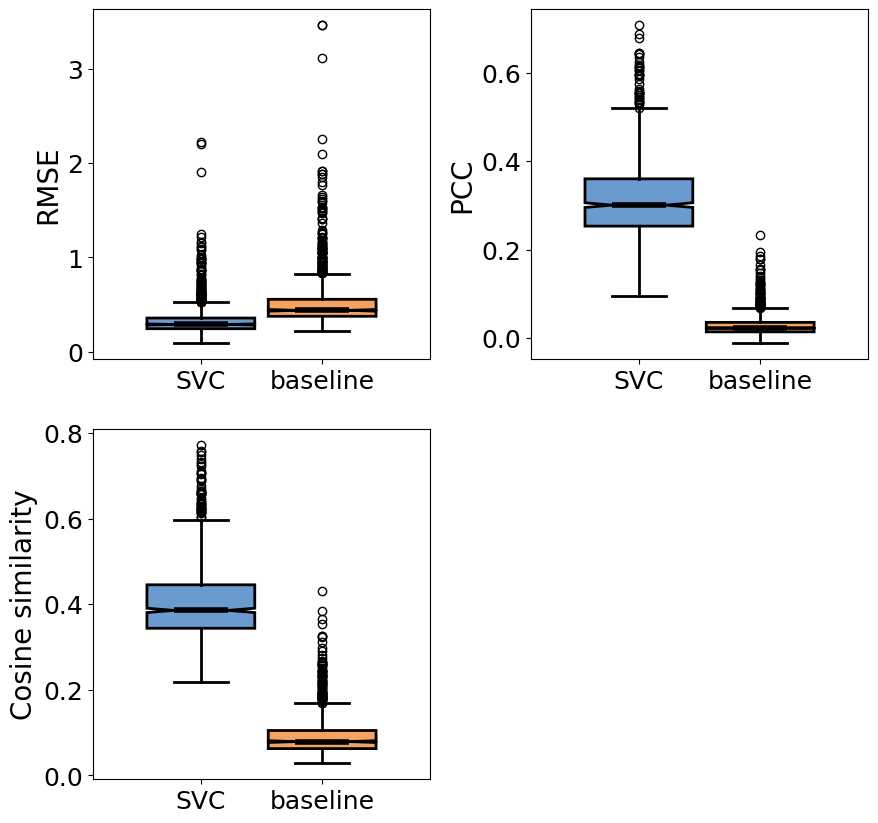

In [12]:

pcc_baseline_avg = pcc_baseline_repeat.mean(axis=0)
pcc_baseline_avg_clear = pcc_baseline_avg[~np.isnan(pcc_baseline_avg)]
cosine_baseline_avg = cosine_baseline_repeat.mean(axis=0)
rmse_baseline_avg = rmse_baseline_repeat.mean(axis=0)


def box_AB(ax, a, b, title, colors=('#6a9ace', '#f4a261')):
    centers = [1]
    offset = 0.18
    pos_A = [centers[0] - offset]
    pos_B = [centers[0] + offset]

    common = dict(
        widths=0.32,
        zorder=10,
        notch=True,
        vert=True,
        patch_artist=True,
        whiskerprops=dict(color='black', linestyle='-', linewidth=2),
        capprops=dict(color='black', linewidth=2),
        flierprops=dict(marker='o', markersize=6, linestyle='none'),
    )

    bpA = ax.boxplot([a], positions=pos_A,
                     boxprops=dict(facecolor=colors[0], linewidth=2),
                     medianprops=dict(linewidth=4, color='black'),
                     **common)
    bpB = ax.boxplot([b], positions=pos_B,
                     boxprops=dict(facecolor=colors[1], linewidth=2),
                     medianprops=dict(linewidth=4, color='black'),
                     **common)


    ax.set_xticks([pos_A[0], pos_B[0]])
    ax.set_xticklabels(['SVC', 'baseline'], fontsize=18)
    ax.set_xlim(0.5, 1.5)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_ylabel(title, fontsize=20)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.2, 'wspace': 0.30})
box_AB(axes[0, 0], avg_rmse_SVC,   rmse_baseline_avg,   'RMSE')
box_AB(axes[0, 1], avg_pcc_SVC,    pcc_baseline_avg_clear,    'PCC')
box_AB(axes[1, 0], avg_cosine_SVC, cosine_baseline_avg, 'Cosine similarity')
axes[1, 1].axis('off')  
plt.tight_layout()
plt.show()



median rmse gain: 0.3602303253380977 0.17653669204134959 0.5963639611849334
median pcc gain: 0.2742026079974916 0.0813107395402345 0.629224406581754
median cosine gain: 0.3046002501442091 0.15925233035338637 0.5510882886011916


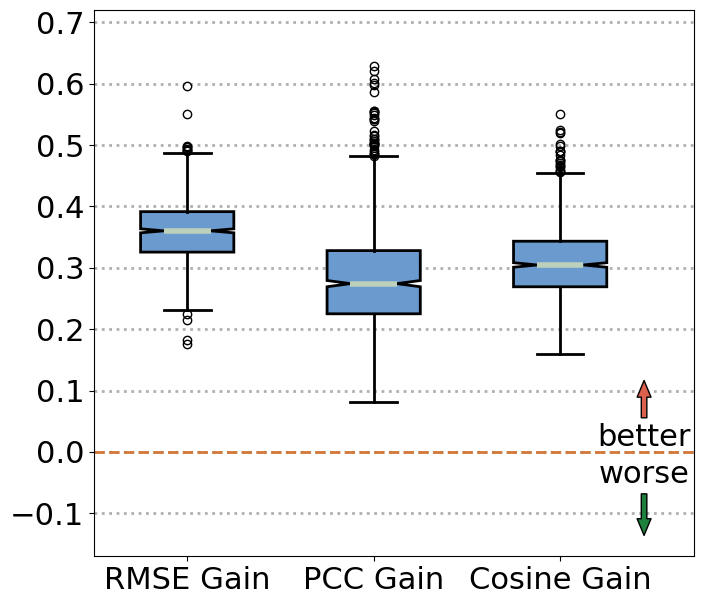

In [13]:
rmse_gain = -(avg_rmse_SVC - rmse_baseline_avg)/rmse_baseline_avg
pcc_gain = (avg_pcc_SVC-pcc_baseline_avg)
pcc_gain = pcc_gain[~np.isnan(pcc_gain)]
cosine_gain = (avg_cosine_SVC-cosine_baseline_avg)

print("median rmse gain:", np.median(rmse_gain),np.min(rmse_gain),np.max(rmse_gain))
print("median pcc gain:", np.median(pcc_gain),np.min(pcc_gain),np.max(pcc_gain))
print("median cosine gain:", np.median(cosine_gain),np.min(cosine_gain),np.max(cosine_gain))


plt.figure(figsize=(7, 6))
plt.boxplot([rmse_gain,pcc_gain,cosine_gain], widths=0.5,zorder=10,#showfliers=False,
    notch=True,
    vert=True,
    patch_artist=True, 
    boxprops=dict(facecolor='#6a9ace', linewidth=2),
    medianprops=dict(linewidth=4,color='#bcd1bc'),
    whiskerprops=dict(color='black', linestyle='-', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    flierprops=dict(marker='o', markersize=6, linestyle='none')
)

plt.axhline(0, color='#d47838', linestyle='--', linewidth=2)
# plt.axhline(np.median(cosine_gain), color='orange', linestyle='--', linewidth=1)

arrow_x = 3.35

plt.annotate(
    'better',                   
    xy=(arrow_x+0.1, 0.12),           
    xytext=(arrow_x+0.1, 0.01),      
    arrowprops=dict(
        facecolor='#db614f',
        shrink=0.05, 
        width=4,          
        headwidth=10
    ),
    fontsize=22,
    ha='center'
)
plt.annotate(
    'worse',
    xy=(arrow_x+0.1, -0.14),
    xytext=(arrow_x+0.1 , -0.05),
    arrowprops=dict(
        facecolor='#1e803d', 
        shrink=0.05, 
        width=4, 
        headwidth=10),
    fontsize=22,
    ha='center'
)


plt.tight_layout()
plt.xlim(0.5, 3.72)  
plt.ylim(-0.17,0.72) 
plt.xticks([1,2,3],["RMSE Gain","PCC Gain","Cosine Gain"], fontsize=22)
plt.yticks(np.arange(-0.1, 0.8, 0.1),fontsize=22)
plt.grid(axis='y', linestyle=':',linewidth=2)
plt.show()


In [4]:
gene_names = np.loadtxt('/net/mulan/home/huiwann/spatial/SVC/data/seqfish/gene_names.txt', dtype=str).tolist()

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, shuffle=True, random_state=2025)#5

groups = []
for train_index, test_index in kf.split(gene_names):
    groups.append(np.array(gene_names)[test_index])

for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['Abcf2' 'Actn1' 'Aldh2' 'Anapc4' 'Atp8b2' 'Calu' 'Chd1' 'Csnk1g2'
 'Ctdsp1' 'Ddb1' 'Ehd1' 'Eif2b1' 'Eif3b' 'Fat1' 'Gtf2f1' 'Hif1a' 'Htra2'
 'Ide' 'Igf1r' 'Itgb1' 'Klhl5' 'Lasp1' 'Mical2' 'Myh10' 'Nadk' 'Ncor2'
 'Nfic' 'Nmnat2' 'Nr2f2' 'Nt5dc2' 'Pelp1' 'Pfkl' 'Phlda3' 'Polr2a'
 'Ppp2ca' 'Rbbp4' 'Rpa2' 'Slc48a1' 'Snx5' 'Sp1' 'Srrt' 'Stat3' 'Stoml2'
 'Syde1' 'Tcf19' 'Trio' 'Tspan5' 'U2af2' 'Wls' 'Ykt6']
Group 2: ['Aebp1' 'Ankrd17' 'Arhgef1' 'Asap1' 'Bag6' 'Bgn' 'Birc6' 'Ccne1'
 'Clptm1l' 'Cotl1' 'Cs' 'Cttn' 'Cyb5r3' 'Cyfip1' 'Dctn1' 'Eif6' 'Fads1'
 'Flnc' 'Gas7' 'Gtf2i' 'Kpnb1' 'Lmf2' 'Lrrc42' 'Mbtps1' 'Mvp' 'Myc'
 'Nap1l4' 'Napa' 'Nfe2l1' 'Npnt' 'Pcolce' 'Phldb2' 'Poldip2' 'Rfc1' 'Rhoq'
 'Rrn3' 'Scaf11' 'Setd5' 'Slc38a10' 'Slk' 'Smarcc1' 'Ssr3' 'Ssrp1'
 'Tagln2' 'Tbrg4' 'Tcof1' 'Tnrc18' 'Tulp4' 'Uap1' 'Ubap2l']
Group 3: ['Aacs' 'Akt1' 'Ankrd13a' 'Casp3' 'Cep170' 'Chaf1b' 'Cherp' 'Col1a1'
 'Col5a1' 'Ddx6' 'Ddx18' 'Dock1' 'Fam114a1' 'Fscn1' 'Fxr2' 'Gas1' 'Gnai3'
 'Grb10' 'Hdac3' 

In [16]:
j=0
for selected_gene in groups:
    gene_to_impute = [gene_names.index(i) for i in selected_gene if i in gene_names]
    rmse_per_gene = np.zeros(len(gene_to_impute))
    for i in range(len(gene_to_impute)):
        real_i = truth_test.sum((-1,-2))[:,gene_to_impute[i]]
        impute_i = predictions.sum((-1,-2))[:,gene_to_impute[i]]
        rmse_per_gene[i] = np.sqrt(np.mean((real_i - impute_i) ** 2))

    np.savetxt(f"/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/SVC/rmse_per_gene_group_{j}.txt", rmse_per_gene)
    j+=1

In [5]:
rmse_per_gene_SVC = np.zeros(1000)
rmse_per_gene_ENVI = np.zeros(1000)
rmse_per_gene_gimVI = np.zeros(1000)
rmse_per_gene_uniPort = np.zeros(1000)
for i in np.arange(20):
    rmse_per_gene_SVC[i*50:(i+1)*50]=np.loadtxt(f"/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/SVC/rmse_per_gene_group_{i}.txt")
    rmse_per_gene_ENVI[i*50:(i+1)*50]=np.loadtxt(f'/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/ENVI/rmse_per_gene_group_{i}.txt')
    rmse_per_gene_gimVI[i*50:(i+1)*50]=np.loadtxt(f"/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/gimVI/rmse_per_gene_group_{i}.txt") 
    rmse_per_gene_uniPort[i*50:(i+1)*50]=np.loadtxt(f'/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/uniPort/rmse_per_gene_group_{i}.txt')
    i+=1
    
print("RMSE per gene SVC",np.median(rmse_per_gene_SVC))
print("RMSE per gene ENVI:", np.median(rmse_per_gene_ENVI))
print("RMSE per gene gimVI:", np.median(rmse_per_gene_gimVI))
print("RMSE per gene uniPort:", np.median(rmse_per_gene_uniPort))

RMSE per gene SVC 5.540400909134814
RMSE per gene ENVI: 7.263912702686211
RMSE per gene gimVI: 6.019874648351867
RMSE per gene uniPort: 7.245942967768865


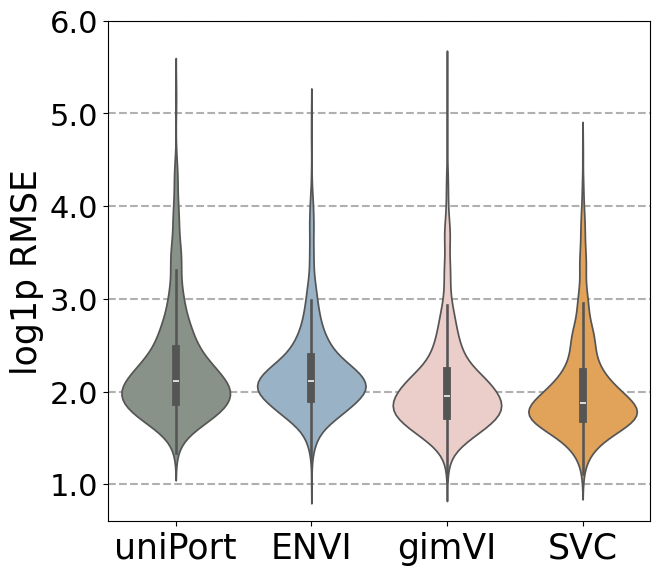

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
colors = ["#879486", "#91b3ce", "#f1cac4", "#f7a444"]
sns.violinplot([np.log1p(rmse_per_gene_uniPort),np.log1p(rmse_per_gene_ENVI), np.log1p(rmse_per_gene_gimVI),np.log1p(rmse_per_gene_SVC)], ax=ax,palette=colors,zorder=2)
for patch, color in zip(ax.artists, colors):     
    patch.set_facecolor(color)
ax.set_ylim(0.6, 5.5)
ax.set_ylabel('log1p RMSE', fontsize=25)
ax.set_yticks(np.arange(1, 6.01, 1))
ax.set_yticklabels(np.arange(1, 6.01, 1), fontsize=22)
ax.set_xticklabels(['uniPort','ENVI', 'gimVI','SVC'], fontsize=25)
plt.grid(axis='y', linestyle='--',linewidth=1.5)

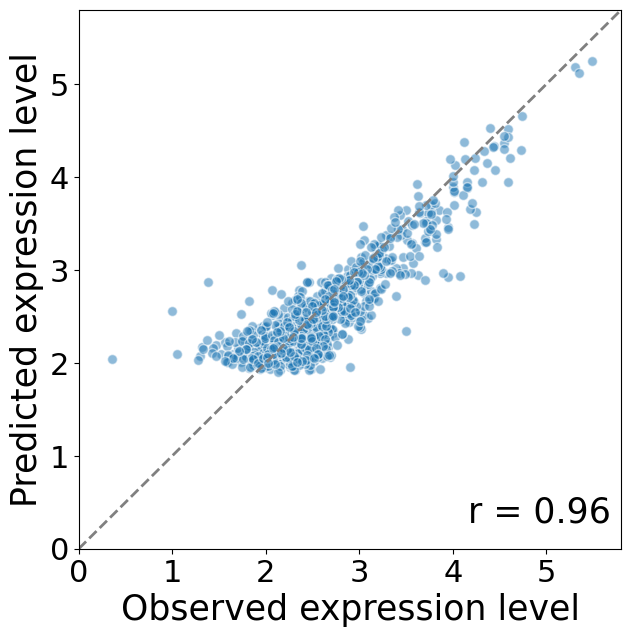

In [6]:
pred_exp_level_SVC = (predictions.sum((-1,-2))).mean(0)
exp_level = (truth_test.sum((-1,-2))).mean(0)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.scatter(np.log1p(exp_level), np.log1p(pred_exp_level_SVC), s=50, alpha=0.5,edgecolors='white')
plt.plot([0, 6], [0, 6], '--', lw=2, color='gray')
plt.xlim(0, 5.8)
plt.ylim(0, 5.8)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([0,1,2,3,4,5],fontsize=22)
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels([0,1,2,3,4,5],fontsize=22)
plt.xlabel('Observed expression level',fontsize=25)
plt.ylabel('Predicted expression level',fontsize=25)
ax.text(0.98, 0.05, f'r = {np.corrcoef(exp_level, pred_exp_level_SVC)[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
plt.show()


In [7]:
cell_gene_prediction_ENVI=np.load(f'/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/ENVI/cell_gene_predictions.npy')     
cell_gene_prediction_gimVI=np.load(f"/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/gimVI/cell_gene_predictions.npy")      
cell_gene_prediction_uniPort=np.load(f'/net/mulan/home/huiwann/spatial/SVC/output/seqfish/compared_methods/uniPort/cell_gene_predictions.npy')
print("cell_gene_prediction_ENVI shape:", cell_gene_prediction_ENVI.shape)
print("cell_gene_prediction_gimVI shape:", cell_gene_prediction_gimVI.shape)
print("cell_gene_prediction_uniPort shape:", cell_gene_prediction_uniPort.shape)

cell_gene_prediction_ENVI shape: (14, 1000)
cell_gene_prediction_gimVI shape: (14, 1000)
cell_gene_prediction_uniPort shape: (14, 1000)


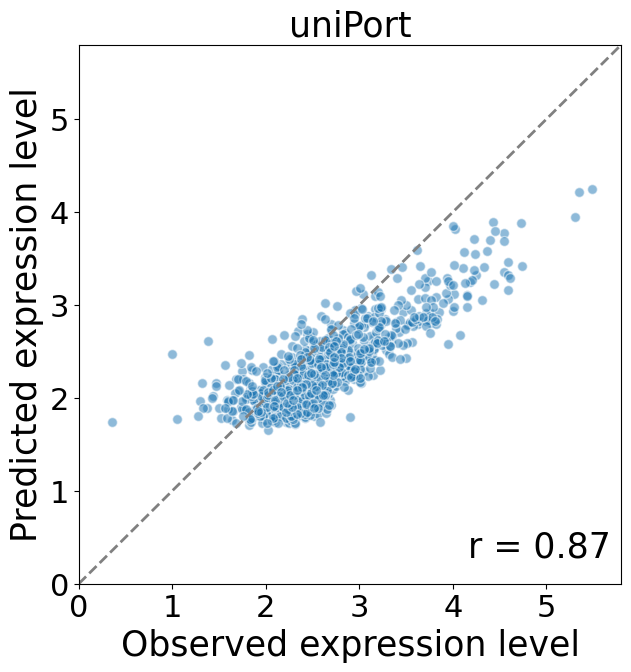

In [8]:
pred_exp_level_uniPort = cell_gene_prediction_uniPort.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.scatter(np.log1p(exp_level), np.log1p(pred_exp_level_uniPort), s=50, alpha=0.5,edgecolors='white')
plt.plot([0, 6], [0, 6], '--', lw=2, color='gray')
plt.xlim(0, 5.8)
plt.ylim(0, 5.8)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([0,1,2,3,4,5],fontsize=22)
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels([0,1,2,3,4,5],fontsize=22)
plt.xlabel('Observed expression level',fontsize=25)
plt.ylabel('Predicted expression level',fontsize=25)
plt.title('uniPort',fontsize=25)
ax.text(0.98, 0.05, f'r = {np.corrcoef(exp_level, pred_exp_level_uniPort)[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
plt.show()


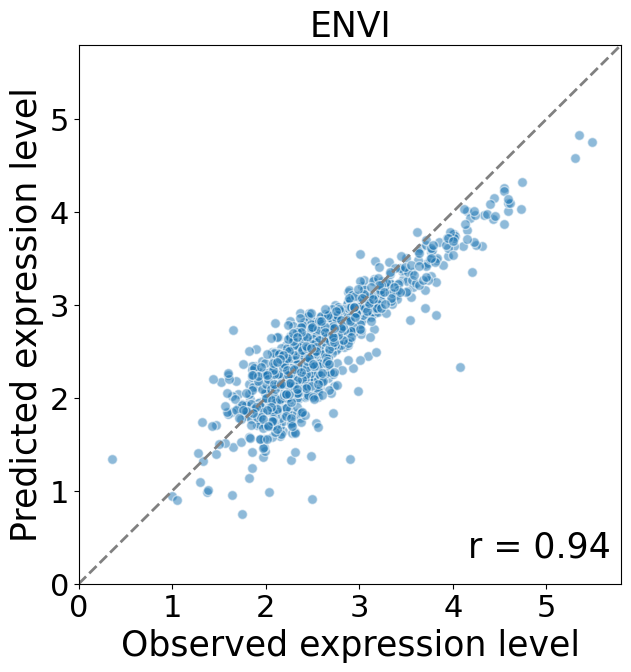

In [9]:
pred_exp_level_ENVI = cell_gene_prediction_ENVI.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.scatter(np.log1p(exp_level), np.log1p(pred_exp_level_ENVI), s=50, alpha=0.5,edgecolors='white')
plt.plot([0, 6], [0, 6], '--', lw=2, color='gray')
plt.xlim(0, 5.8)
plt.ylim(0, 5.8)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([0,1,2,3,4,5],fontsize=22)
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels([0,1,2,3,4,5],fontsize=22)
plt.xlabel('Observed expression level',fontsize=25)
plt.ylabel('Predicted expression level',fontsize=25)
plt.title('ENVI',fontsize=25)
ax.text(0.98, 0.05, f'r = {np.corrcoef(exp_level, pred_exp_level_ENVI)[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
plt.show()


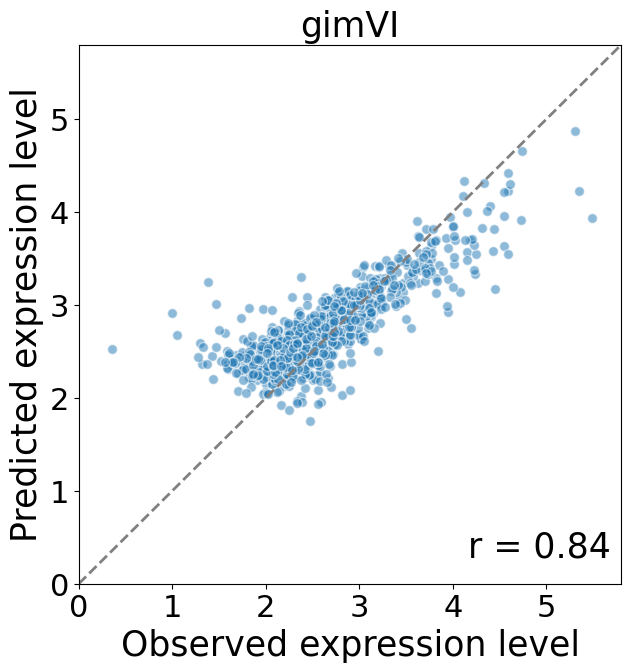

In [10]:
pred_exp_level_gimVI = cell_gene_prediction_gimVI.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.scatter(np.log1p(exp_level), np.log1p(pred_exp_level_gimVI), s=50, alpha=0.5,edgecolors='white')
plt.plot([0, 6], [0, 6], '--', lw=2, color='gray')
plt.xlim(0, 5.8)
plt.ylim(0, 5.8)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([0,1,2,3,4,5],fontsize=22)
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels([0,1,2,3,4,5],fontsize=22)
plt.xlabel('Observed expression level',fontsize=25)
plt.ylabel('Predicted expression level',fontsize=25)
plt.title('gimVI',fontsize=25)
ax.text(0.98, 0.05, f'r = {np.corrcoef(exp_level, pred_exp_level_gimVI)[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
plt.show()
